In [37]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [38]:
# add Code folder
import sys
sys.path.append('../qatpack')

import numpy as np
from experiment import Experiment
from plotting import plot_polytopes
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

## Device definition

In this cells we define the device from [Neyens et al.](https://journals.aps.org/prapplied/abstract/10.1103/PhysRevApplied.12.064049). It consist of four target dots (indices 0-3) and two sensor dots (indices 4,5). The device is depicted in Fig below. The device is defined by the following parameters:
- C_DD - capacitance between the dots
- C_Dg - capacitance between the dots and the gates
- tc - tunneling rate between the dots


<img src="../qatpack/figures/device.png" alt="drawing" width="600"/>

In [39]:
# Define the system

#All capacitances are given in aF
N = 6 #number of dots   
C_DD=20* np.eye((N))/2 #The self-capacitance of each dot, NOTE: factor of 2 due to symmetrization
C_DD[0,1] = 10 #capacitance between dot 0 and dot 1 (Left double dot) 
C_DD[2,3] = 7 #capacitance between dot 3 and dot 4 (Right double dot)

C_DD[0,4] = 1.6 #capacitance between sensor dot 4 and dot 0
C_DD[1,4] = 1.4 #capacitance between sensor dot 4 and dot 1
C_DD[2,5] = 1.4 #capacitance between sensor dot 5 and dot 2
C_DD[3,5] = 2 #capacitance between sensor dot 5 and dot 3
C_DD[1,2] = 6 #capacitance between the middle dots 2 and dot 3
C_DD = C_DD + C_DD.T

C_DG=11*np.eye(N) #dot-to-gate capacitances 
#cross-capacitances
C_DG[0,1] = 1.5 #dot 0 from dot 1
C_DG[1,0] = 1.2 #dot 1 from dot 0
C_DG[2,3] = 1.3 #dot 2 from dot 3
C_DG[3,2] = 1.4 #dot 3 from dot 3

# Definition of the tunnel couplings in eV 
# NOTE: we use the convention that tc is the energy gap at avoided crossing H = tc/2 sx
tunnel_couplings = np.zeros((N,N))
tunnel_couplings[0,1] = 50*1e-6
tunnel_couplings[1,0] = 50*1e-6
tunnel_couplings[2,3] = 60*1e-6
tunnel_couplings[3,2] = 60*1e-6

In [40]:
capacitance_config = {
        "C_DD" : C_DD,  #dot-dot capacitance matrix
        "C_Dg" : C_DG,  #dot-gate capacitance matrix
        "ks" : 4,       #distortion of Coulomb peaks. NOTE: If None -> constant size of Coublomb peak 
}

tunneling_config = {
        "tunnel_couplings": tunnel_couplings, #tunnel coupling matrix
        "temperature": 0.1,                   #temperature in Kelvin
        "energy_range_factor": 5,  #energy scale for the Hamiltonian generation. NOTE: Smaller -> faster but less accurate computation 
}
sensor_config = {
        "sensor_dot_indices": [4,5],  #Indices of the sensor dots
        "sensor_detunings": [-0.0005,-0.0005],  #Detuning of the sensor dots
        "noise_amplitude": {"fast_noise": 0.6*1e-6, "slow_noise": 1e-8}, #Noise amplitude for the sensor dots in eV
        "peak_width_multiplier": 15,  #Width of the sensor peaks in the units of thermal broadening m *kB*T/0.61.
}


In [41]:
# Create the experiment object from the configuration files
experiment = Experiment(capacitance_config, tunneling_config, sensor_config)

EXPERIMENT INITIALIZED
-----------------------

                Capacitance model deployed with the following parameters:
                Dot-dot capacitances: 
                [[20.  10.   0.   0.   1.6  0. ]
 [10.  20.   6.   0.   1.4  0. ]
 [ 0.   6.  20.   7.   0.   1.4]
 [ 0.   0.   7.  20.   0.   2. ]
 [ 1.6  1.4  0.   0.  20.   0. ]
 [ 0.   0.   1.4  2.   0.  20. ]]
                Dot-gate capacitances: 
                [[11.   1.5  0.   0.   0.   0. ]
 [ 1.2 11.   0.   0.   0.   0. ]
 [ 0.   0.  11.   1.3  0.   0. ]
 [ 0.   0.   1.4 11.   0.   0. ]
 [ 0.   0.   0.   0.  11.   0. ]
 [ 0.   0.   0.   0.   0.  11. ]]
                Size of Coulomb peaks V[n] is constant
                

            Sensor model deployed with the following parameters:   
            Sensor dot indices: [4, 5]
            Sensor detunings: [-0.5 -0.5] meV
            Coulomb peak width: 0.41 meV
            Slow noise amplitude: 0.01 ueV
            Fast noise amplitude: 0.6 ueV
            

   

## Figure 1: Four dot transition from Neyens et al. 2019

In the first example we reconstruct the four dot transition from Neyens et al. 2019. This is done by selecting:
- plane_axes = $[[0,0,-1,1,0,0],[1,-1,0,0,0,0]]$ - i.e. alligning x-axis with transition between 3 and 4 dot and y-axis with transition between 1 and 2 dot
- target_state = $[3,2,3,2,5,5]$ - i.e. selecting the state for the center transition
- target_transition = $[-1,1,-1,1,0,0]$ - finds energy offset, which moves four-dot transition between the states $[3,2,3,2,5,5]$ and $[2,3,2,3,5,5]$ to the origin
- x_voltages - voltage range for the x-axis
- y_voltages - voltage range for the y-axis
- compute_politopes - compute the regions of constant charge occupation for the device
- compensate_sensors - compensate for a drift of sensor dot
- use_virtual_gate - allign the CSD with the transitions selected in plane_axes 
- use_sensor_signal - return conductance of the dots

In [42]:
xexp, yexp, _, polytopesexp, sensor_signalexp, _ = experiment.generate_CSD(
                                                plane_axes = np.array([[0,0,-1,1,0,0],[1,-1,0,0,0,0]]), # vectors spanning the cut in voltage space
                                                target_state = [3,2,3,2,5,5],  # target state for transition
                                                target_transition = [-1,1,-1,1,0,0], #target transition from target state, here transition to [2,3,2,3,5,5]
                                                x_voltages=np.linspace(-0.002, 0.002, 100), #voltage range for x-axis
                                                y_voltages=np.linspace(-0.002, 0.002, 100), #voltage range for y-axis
                                                compute_polytopes = True, #compute the corners of constant occupation
                                                compensate_sensors=True, #compensate the sensor signals
                                                use_virtual_gates=True, #use the virtual gates
                                                use_sensor_signal=True) #use the sensor signals

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
V_offset found: [0.02893633 0.02977506 0.02942368 0.02924915]
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


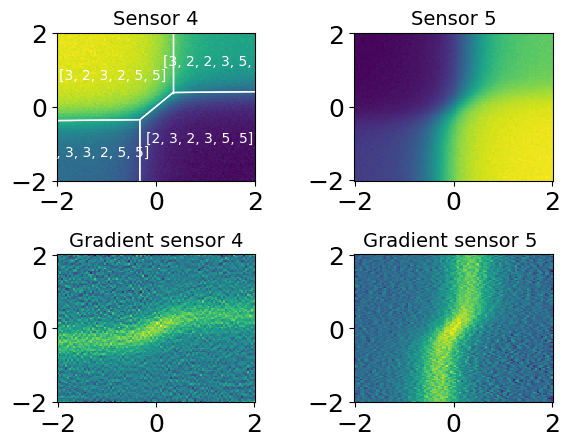

In [11]:
# Control plot
fig, ax = plt.subplots(2,2)
plt.subplots_adjust(wspace=0.5, hspace=0.5)
#Conductance of the dot 4 (Left sensor dot)
ax[0,0].set_title("Sensor 4", fontsize=14)
ax[0,0].pcolormesh(1e3*xexp,1e3*yexp,sensor_signalexp[:,:,0])
plot_polytopes(ax[0,0],polytopesexp, axes_rescale=1e3)  # plot the polytopes to see the constant occupation regions
ax[0,0].set_xlim(xexp[0]*1e3,xexp[-1]*1e3)
ax[0,0].set_ylim(yexp[0]*1e3,yexp[-1]*1e3) 
#NOTE: Default voltage unit is V, so with 1e3 we convert it to mV #TODO implement the voltage unit conversion

#Conductance of the dot 5 (Right sensor dot)
ax[0,1].set_title("Sensor 5", fontsize=14)
ax[0,1].pcolormesh(1e3*xexp,1e3*yexp,sensor_signalexp[:,:,1])    

#Gradient of the left sensor along the y axis #NOTE: for np.array y-axis means axis=0.
ax[1,0].set_title("Gradient sensor 4", fontsize=14)
ax[1,0].pcolormesh(1e3*xexp,1e3*yexp,np.gradient(sensor_signalexp[:,:,0],axis=0))

#Gradient of the left sensor along the x axis #NOTE: for np.array x-axis means axis=1.
ax[1,1].set_title("Gradient sensor 5 ", fontsize=14)
ax[1,1].pcolormesh(1e3*xexp,1e3*yexp,np.gradient(sensor_signalexp[:,:,1],axis=1))

Text(0, 0.5, 'Detuning $\\epsilon_{L}/\\alpha$ (mV)')

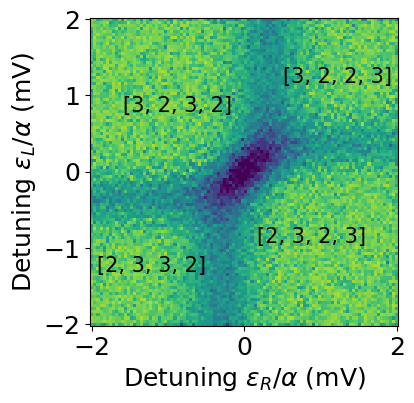

In [12]:
#Plot main figure
fig, ax = plt.subplots(figsize=(5,4))
left_dot_factor = 2.5 #factor to make the intensities of both sensor equal (similairy to the experiment)
sum_sensor_gradient = left_dot_factor*np.abs(np.gradient(sensor_signalexp[:,:,0],axis=0)
                                  ) + np.abs(np.gradient(sensor_signalexp[:,:,1],axis=1))  #sum of gradients

ax.pcolormesh(1e3*xexp,1e3*yexp,sum_sensor_gradient/np.max(sum_sensor_gradient),
                                            cmap="viridis_r",vmin=-0.1, vmax=0.8) #plot the sum of gradients
ax.set_aspect('equal', 'box')

#plot polytopes. NOTE: only_labels=True -> plot only the labels of the polytopes, skip_dots=[4,5] -> skip the sensor indices
plot_polytopes(ax, polytopesexp, axes_rescale=1e3, only_labels=True, fontsize=15, color="black", skip_dots = [4,5])

#labels
plt.xlabel(r'Detuning $\epsilon_{R}/\alpha$ (mV)')
plt.ylabel(r'Detuning $\epsilon_{L}/\alpha$ (mV)')

### Figure 4: Charge stability diagram with varying Coulomb peak size

In this example we test the effect of varying Coulomb peak size on the charge stability diagram. This is controlled by the capacitance configuration file, through the parameter ks. 

In [352]:
# Generate the simplest CSD diagram
xks, yks, csd_dataks, polytopesks, _, _ = experiment.generate_CSD(
                                        x_voltages = np.linspace(0, 0.06, 500),  #V
                                        y_voltages = np.linspace(0, 0.03, 100),  #V
                                        plane_axes = [[1,0,0,0,0,0],[0,1,0,0,0,0]], #NOTE: with defauls use_virtual_gates = False, this means voltages.
                                        compute_polytopes =  True)                


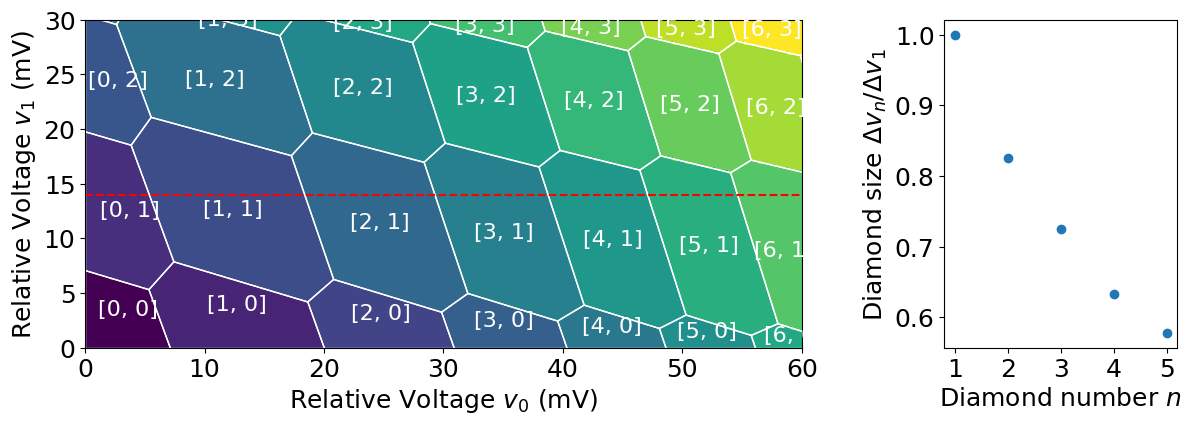

In [382]:

# Create a figure
fig = plt.figure(figsize=(12, 4))


# Define the grid
gs = gridspec.GridSpec(1, 2, width_ratios=[4, 1.3])
plt.subplots_adjust(wspace=0.3, top = 0.98, bottom = 0.16, left = 0.08, right = 0.99)

# Create subplots
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])


#plot the csd with background polytopes
ax0.pcolormesh(1e3*xks,1e3*yks,csd_dataks) #plot the background
plot_polytopes(ax0,polytopesks, axes_rescale = 1e3, skip_dots=[2,3,4,5], fontsize=16) #plot the polytopes

# plot customisation
ax0.set_xlabel('Relative Voltage $v_0$ (mV)')
ax0.set_ylabel('Relative Voltage $v_1$ (mV)')
ax0.set_xlim(xks[0]*1e3,xks[-1]*1e3)
ax0.set_ylim(yks[0]*1e3,yks[-1]*1e3)


# computation of the line-cut data
cut_voltage = 14*1e-3 #select the voltage at which the line-cut is taken
indx = np.argmin(np.abs(yks-cut_voltage)) #find corresponding index
labels = set(csd_dataks[indx,:])
addition_energies = [np.sum(csd_dataks[indx,:]==label) for label in labels]

#plot the line-cut data
ax1.plot(np.arange(1,6),addition_energies[1:-1]/addition_energies[1], "o")
ax1.set_ylabel(r"Diamond size $\Delta v_{n}/\Delta v_{1}$")
ax1.set_xlabel(r"Diamond number $n$")
ax1.set_xticks(np.arange(1,6))
ax0.hlines(yks[indx]*1e3, xks[0]*1e3, xks[-1]*1e3, color="r", linestyle="--")


plt.savefig("figures/fig4.png")


### Figure 5: Finding particulair transition

.Here we show the ability to select the transition in high-dimensional voltage space. We compare two-dot and four-dot transition

In [397]:
# Two-dot transition
x2, y2, csd_data2, polytopes2, _, _ = experiment.generate_CSD(
                                    x_voltages = np.linspace(-0.015, 0.015, 100),  #V
                                    y_voltages = np.linspace(-0.015, 0.015, 100),  #V            
                                    plane_axes = [[1,0,0,0,0,0],[0,1,0,0,0,0]],
                                    compute_polytopes =  True,
                                    target_state=[2,1,5,3,4,4], #target state for the transition
                                    target_transition=[-1,1,0,0,0,0])  #target transition from the target state




V_offset found: [0.01825755 0.01984214 0.05132545 0.03493506 0.04909741 0.04986671]
[[1 0]
 [0 1]
 [0 0]
 [0 0]
 [0 0]
 [0 0]] [0.01825755 0.01984214 0.05132545 0.03493506 0.04909741 0.04986671]


In [398]:
#Four-dot-transition
x4, y4, csd_data4, polytopes4, _, _ = experiment.generate_CSD(
                                    x_voltages = np.linspace(-0.005, 0.005, 100),  #V
                                    y_voltages = np.linspace(-0.005, 0.005, 100),  #V
                                    plane_axes = [[1,0,0,0,0,0],[0,1,0,0,0,0]],
                                    compute_polytopes =  True,
                                    target_state=[2,1,5,3,4,4],
                                    target_transition=[-1,1,-1,1,0,0])                


V_offset found: [0.01871567 0.02037499 0.04581756 0.03699487 0.05022946 0.05079063]
[[1 0]
 [0 1]
 [0 0]
 [0 0]
 [0 0]
 [0 0]] [0.01871567 0.02037499 0.04581756 0.03699487 0.05022946 0.05079063]


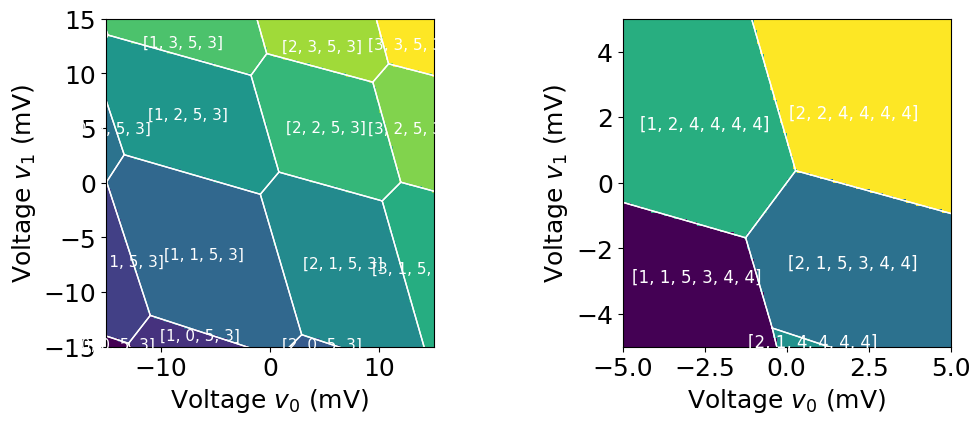

In [399]:
# Create a figure
fig = plt.figure(figsize=(10, 4))


# Define the grid
gs = gridspec.GridSpec(1, 2, width_ratios=[1.3, 1.3])
plt.subplots_adjust(wspace=0.25, top = 0.98, bottom = 0.16, left = 0.06, right = 0.99)

#Two-dot transition plotting
ax0 = plt.subplot(gs[0])
ax0.pcolormesh(1e3*x2,1e3*y2,csd_data2) 
plot_polytopes(ax0,polytopes2, axes_rescale = 1e3, skip_dots=[4,5], fontsize=11)
ax0.set_xlabel('Voltage $v_0$ (mV)')
ax0.set_ylabel('Voltage $v_1$ (mV)')
ax0.set_xlim(x2[0]*1e3,y2[-1]*1e3)
ax0.set_ylim(y2[0]*1e3,y2[-1]*1e3)
ax0.set_aspect('equal')

#Four-dot transition plotting
ax1 = plt.subplot(gs[1])
ax1.pcolormesh(1e3*x4,1e3*y4,csd_data4) 
plot_polytopes(ax1,polytopes4, axes_rescale = 1e3, fontsize=12, color="white")
ax1.set_xlabel('Voltage $v_0$ (mV)')
ax1.set_ylabel('Voltage $v_1$ (mV)')
ax1.set_xlim(x4[0]*1e3,x4[-1]*1e3)
ax1.set_ylim(y4[0]*1e3,y4[-1]*1e3)
ax1.set_aspect('equal')
plt.savefig("figures/fig5_target.png")

### Fig 6: Virtualisation

We now showcase gate virtualisation, i.e. allignment of the transition with selectaed axes in plane_axes. 

In [33]:
#Show the transition without gate virtualisation
xnV, ynV, csd_datanV, polytopesnV, _, _ = experiment.generate_CSD(
                                        x_voltages = np.linspace(-0.005, 0.015, 100),  #V
                                        y_voltages = np.linspace(-0.001, 0.019, 100),  #V
                                        plane_axes = [[1,0,0,0,0,0],[0,1,0,0,0,0]],
                                        compute_polytopes =  True,
                                        target_state=[5,4,5,5,5,5],
                                        target_transition=[1,0,0,0,0,0], #Transtiion from [5,4,5,5,5,5] -> [6,4,5,5,5,5] at v=0.
                                        compensate_sensors=False)   


V_offset found: [0.05306243 0.04244193 0.04984212 0.04984418 0.0561569  0.05628286]


In [13]:
#Show the same transition with gate virtualisation
xV, yV, csd_dataV, polytopesV, _ ,_ = experiment.generate_CSD(
                                x_voltages = np.linspace(-0.005, 0.015, 100),  #V
                                y_voltages = np.linspace(-0.001, 0.019, 100),  #V
                                plane_axes = [[1,0,0,0,0,0],[0,1,0,0,0,0]],
                                compute_polytopes =  True,
                                target_state=[5,4,5,5,5,5],
                                target_transition=[1,0,0,0,0,0] ,                      
                                use_virtual_gates= True)   # Now we change it to True

V_offset found: [0.05306243 0.04244193 0.04984212 0.04984418 0.0561569  0.05628286]


ValueError: operands could not be broadcast together with shapes (607,4) (6,) 

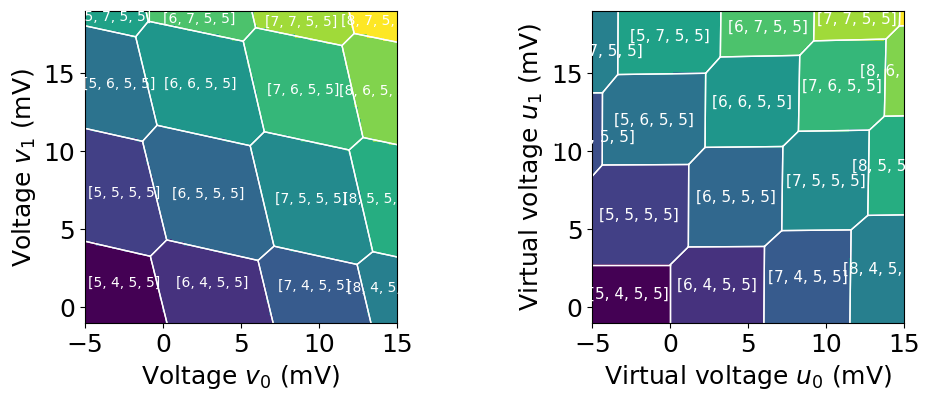

In [34]:

# Create a figure
fig = plt.figure(figsize=(10, 4))


# Define the grid
gs = gridspec.GridSpec(1, 2, width_ratios=[1.3, 1.3])
plt.subplots_adjust(wspace=0.2, top = 0.96, bottom = 0.18, left = 0.06, right = 0.99)

# Create subplots
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])


#plot the csd with background polytopes
ax0.pcolormesh(1e3*xnV,1e3*ynV,csd_datanV) 
plot_polytopes(ax0,polytopesnV, axes_rescale = 1e3, skip_dots = [4,5], fontsize=10)

ax1.pcolormesh(1e3*xV,1e3*yV,csd_dataV)
plot_polytopes(ax1,polytopesV, axes_rescale = 1e3, skip_dots = [4,5], fontsize=11)

# plot customisation
ax0.set_xlabel('Voltage $v_0$ (mV)')
ax0.set_ylabel('Voltage $v_1$ (mV)')
ax0.set_xlim(xnV[0]*1e3,xnV[-1]*1e3)
ax0.set_ylim(ynV[0]*1e3,ynV[-1]*1e3)
ax0.set_aspect('equal')

# plot customisation
ax1.set_xlabel('Virtual voltage $u_0$ (mV)')
ax1.set_ylabel('Virtual voltage $u_1$ (mV)')
ax1.set_xlim(xV[0]*1e3,xV[-1]*1e3)
ax1.set_ylim(yV[0]*1e3,yV[-1]*1e3)
ax1.set_aspect('equal')
plt.savefig("fig6_virtual.png")


### Fig 7: Sensor parameters

We now show the consequence of different source of the noise:
- Fast noise: noise that is present in the sensor signal and is fast compared to the measurement time.
- Slow noise: noise that is present in the sensor signal and is slow compared to the measurement time.
- Temperature (relevant for tunnel coupling simulations)

In [402]:
# We define the baseline configuration files:
sensor_config_base = {
        # Specify list of indices of dots that are sensors
        "sensor_dot_indices": [4,5],
        # Specify a list of the same length, with detuning for each sensor        
        "noise_amplitude": {"fast_noise": 1e-99, "slow_noise": 1e-99},  # sigma of the noise in eV, typically 10 ueV
        "peak_width_multiplier": 10,   # broedening of the peak due to tunnel coupling to reservoir, width = p_w_m*0.12meV*T/0.1K
        "sensor_detunings": [3*1e-4,3*1e-4],    #detuning from the center of coulomb peak in eV, typically ~ peak width

}

tunneling_config_base = {
        "tunnel_couplings": tunneling,
        "temperature": 0.1,
        "energy_range_factor": 5,
}



#Here we define the parameters to be scanned in four different experiments
experiment_params = [{"slow_noise_amp": 1e-99, "fast_noise_amp": 1e-99, "temperature": 0.1, "width": 20},
                     {"slow_noise_amp": 1e-99, "fast_noise_amp": 50*1e-6, "temperature": 0.1, "width": 20},
                     {"slow_noise_amp": 30*1e-6, "fast_noise_amp": 1e-99, "temperature": 0.1,  "width":20},
                     {"slow_noise_amp": 1e-99, "fast_noise_amp": 1e-99, "temperature": 0.5, "width": 4},]
#NOTE: In the last experiment we keep width of Coulomb peak constant by compensating temperature with peak_width_multiplier.

# Generation of four different experiment objects:
sensor_experiment = []
for params in experiment_params:
        sensor_config = sensor_config_base.copy()
        tunneling_config = tunneling_config_base.copy()

        sensor_config["noise_amplitude"] = {"fast_noise": params["fast_noise_amp"], "slow_noise": params["slow_noise_amp"]}
        tunneling_config["temperature"] = params["temperature"]
        sensor_config["peak_width_multiplier"] = params["width"]  
        sensor_experiment.append(Experiment(capacitance_config, tunneling_config, sensor_config))
       



        Sensor model deployed with the following parameters:   
        Sensor dot indices: [4, 5]
        Sensor detunings: [0.3 0.3] meV
        Coulomb peak width: 0.55 meV
        Slow noise amplitude: 0.0 ueV
        Fast noise amplitude: 0.0 ueV
        

        Sensor model deployed with the following parameters:   
        Sensor dot indices: [4, 5]
        Sensor detunings: [0.3 0.3] meV
        Coulomb peak width: 0.55 meV
        Slow noise amplitude: 0.0 ueV
        Fast noise amplitude: 50.0 ueV
        

        Sensor model deployed with the following parameters:   
        Sensor dot indices: [4, 5]
        Sensor detunings: [0.3 0.3] meV
        Coulomb peak width: 0.55 meV
        Slow noise amplitude: 30.0 ueV
        Fast noise amplitude: 0.0 ueV
        

        Sensor model deployed with the following parameters:   
        Sensor dot indices: [4, 5]
        Sensor detunings: [0.3 0.3] meV
        Coulomb peak width: 0.55 meV
        Slow noise amplitude: 0.0 u

In [363]:
# Compute CSD in four experiments defined in the previous cell (It takes about 4x2min)
sensor_signal_list = []
polytopes_list = []

for k in range(4):
        x,y, CSD_data, polytopes1, sensor_signal, _ = sensor_experiment[k].generate_CSD(
                                                x_voltages = np.linspace(-0.01, 0.010, 100),
                                                y_voltages = np.linspace(-0.015, 0.015, 100),
                                                plane_axes = [[1,0,0,0,0,0],[0,1,0,0,0,0]],
                                                target_state = [2,3,1,4,5,5],
                                                target_transition = [0,1,0,0,0,0],
                                                compensate_sensors = True, #Sensors are conmpensated to not affects noise effects
                                                use_virtual_gates = False,
                                                compute_polytopes = True,
                                                use_sensor_signal = True
                            )
        sensor_signal_list.append(sensor_signal)
        polytopes_list.append(polytopes1)

    

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
V_offset found: [0.02099275 0.03913514 0.01315959 0.04491494]
[[1 0]
 [0 1]
 [0 0]
 [0 0]] [0.02099275 0.03913514 0.01315959 0.04491494]
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
V_offset found: [0.02099275 0.03913514 0.01315959 0.04491494]
[[1 0]
 [0 1]
 [0 0]
 [0 0]] [0.02099275 0.03913514 0.01315959 0.04491494]
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Inte

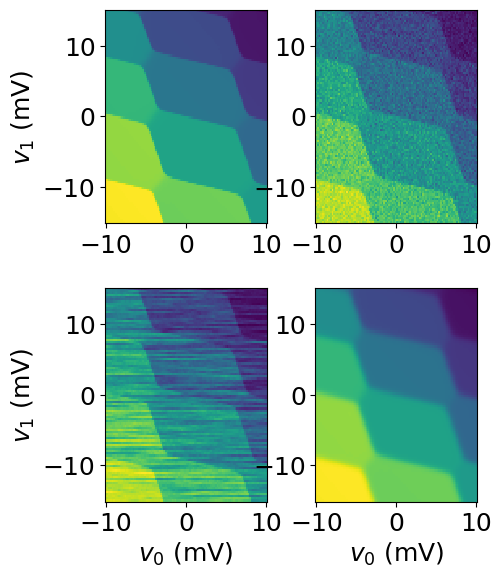

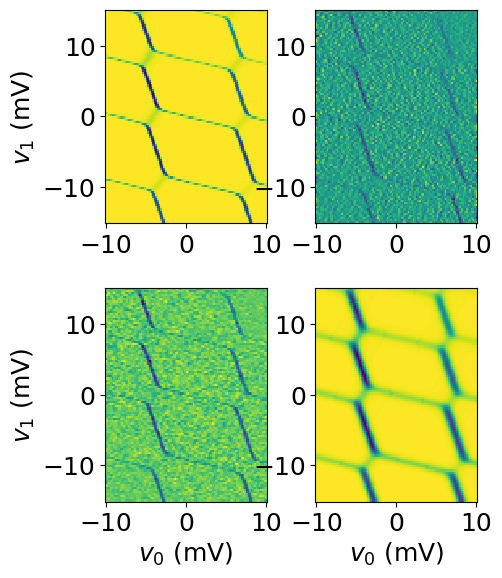

In [365]:
#Plot of the four experiments and the gradients
#Generate 2x2 plot number 1 (signals)
fig, axs = plt.subplots(2,2, figsize = (4,6))
plt.subplots_adjust(wspace=0.3, hspace=0.3, top = 0.98, bottom = 0.16, left = 0.06, right = 0.99)

#Generate 2x2 plot number 2 (gradients)
fig, axs2 = plt.subplots(2,2, figsize = (4,6))
plt.subplots_adjust(wspace=0.3, hspace=0.3, top = 0.98, bottom = 0.16, left = 0.06, right = 0.99)


for k in range(4):
    ax = axs[k//2,k%2]
    ax2 = axs2[k//2,k%2]
    ax.pcolormesh(1e3*x,1e3*y,sensor_signal_list[k][:,:,0], cmap="viridis_r") 
    ax2.pcolormesh(1e3*x,1e3*y,
                    np.gradient(sensor_signal_list[k][:,:,0],axis=1),cmap="viridis_r") #gradient along x-axis
    if k%2==0:
        ax.set_ylabel('$v_1$ (mV)')
        ax2.set_ylabel('$v_1$ (mV)')
    if k//2==1:
        ax.set_xlabel('$v_0$ (mV)')
        ax2.set_xlabel('$v_0$ (mV)')
    


### Fig 8: Tunnel coupling and sensor compensation

In the last example we show the effect of tunnel coupling on the charge stability diagram, manifesting itself as a level repulsin. It is controlled by the parameter tc in the device configuration file. Additionally, we show how the sensor compensation works.

In [45]:
# Plot without sensor compensation
%load_ext autoreload
%autoreload 2
xtc, ytc, CSD_data, polytopestc, sensor_signaltc, _ = experiment.generate_CSD(
                                x_voltages = np.linspace(-0.004, 0.002, 100),
                                y_voltages = np.linspace(-0.003, 0.003, 100),
                                plane_axes = [[0,0,1,0,0,0],[0,0,0,1,0,0]],
                                target_state = [2,1,3,2,4,4], 
                                target_transition = [0,0,1,-1,0,0],
                                compute_polytopes = True,
                                compensate_sensors = False,
                                use_virtual_gates = False,
                                use_sensor_signal=True
                                )

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
[[ 1  0  0  0  0  0]
 [-1  0  0  0  0  0]
 [ 0  1  0  0  0  0]
 ...
 [-1  1  1 -1 -1 -1]
 [ 0 -1  1 -1 -1 -1]
 [ 1 -1  1 -1 -1 -1]]
[ 0  0  1 -1  0  0]
V_offset found: [0.02796662 0.01679969 0.03875483 0.01674422 0.04986768 0.04964416]


In [46]:
# Plot with sensor compensation
xtcC, ytcC, CSD_data, polytopestcC, sensor_signaltcC, _ = experiment.generate_CSD(
                                x_voltages = np.linspace(-0.004, 0.002, 100),
                                y_voltages = np.linspace(-0.003, 0.003, 100),
                                plane_axes = [[0,0,1,0,0,0],[0,0,0,1,0,0]],
                                target_state = [2,1,3,2,4,4], 
                                target_transition = [0,0,-1,1,0,0],
                                compute_polytopes = True,
                                compensate_sensors = True,
                                use_virtual_gates = False,
                                use_sensor_signal=True
                                )

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
[[ 1  0  0  0]
 [-1  0  0  0]
 [ 0  1  0  0]
 [-1  1  0  0]
 [ 0 -1  0  0]
 [ 1 -1  0  0]
 [ 0  0  1  0]
 [ 1  0  1  0]
 [-1  0  1  0]
 [ 0  1  1  0]
 [-1  1  1  0]
 [ 0 -1  1  0]
 [ 1 -1  1  0]
 [ 0  0 -1  0]
 [ 1  0 -1  0]
 [-1  0 -1  0]
 [ 0  1 -1  0]
 [-1  1 -1  0]
 [ 1 -1 -1  0]
 [ 0  0  0  1]
 [ 1  0  0  1]
 [-1  0  0  1]
 [ 0  1  0  1]
 [-1  1  0  1]
 [ 0 -1  0  1]
 [ 1 -1  0  1]
 [ 0  0  1  1]
 [-1  0  1  1]
 [ 0 -1  1  1]
 [ 1 -1  1  1]
 [ 0  0 -1  1]
 [ 1  0 -1  1]
 [-1  0 -1  1]
 [ 0  1 -1  1]
 [-1  1 -1  1]
 [ 0 -1 -1  1]
 [ 1 -1 -1  1]
 [ 0  0  0 -1]
 [ 1  0  0 -1]
 [-1  0  0 -1]
 [ 0  1  0 -1]
 [-1  1  0 -1]
 [ 0 -1  0 -1]
 [ 1 -1  0 -1]
 [ 0  0  1 -1]
 [ 1  0  1 -1]
 [-1  0  1 -1]
 [ 0  1  1 -1]
 [-1  1  1 -1]
 [ 0 -1  1 -1]


FileNotFoundError: [Errno 2] No such file or directory: 'figures/fig8_tunnelcouling.png'

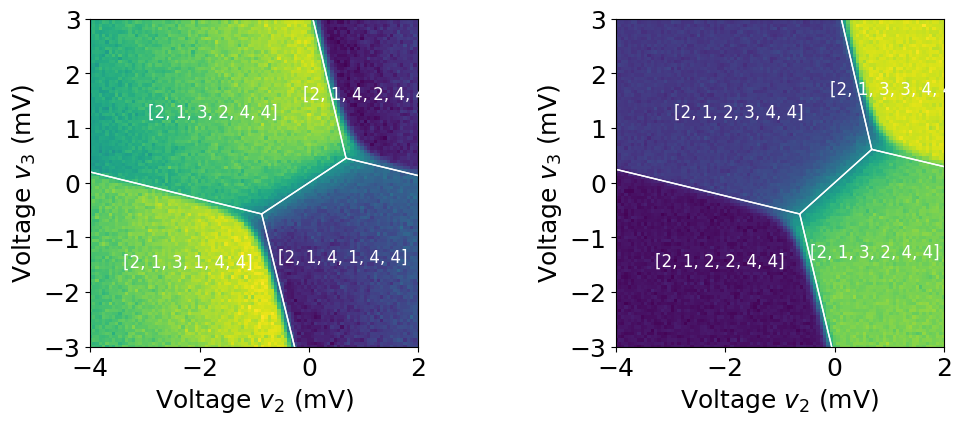

In [47]:
#plotting 
import matplotlib.gridspec as gridspec

# Create a figure
fig = plt.figure(figsize=(10, 4))


# Define the grid
gs = gridspec.GridSpec(1, 2, width_ratios=[1.3, 1.3])
plt.subplots_adjust(wspace=0.3, top = 0.98, bottom = 0.16, left = 0.06, right = 0.99)

#plot without sensor compensation
ax0 = plt.subplot(gs[0])
ax0.pcolormesh(1e3*xtc,1e3*ytc,sensor_signaltc[:,:,0])
plot_polytopes(ax0, polytopestc, axes_rescale=1e3, fontsize = 12) 
ax0.set_xlim(xtc[0]*1e3,xtc[-1]*1e3)
ax0.set_ylim(ytc[0]*1e3,ytc[-1]*1e3)
ax0.set_xlabel('Voltage $v_2$ (mV)')
ax0.set_ylabel('Voltage $v_3$ (mV)')
ax0.set_aspect('equal')

#plot with sensor compensation
ax1 = plt.subplot(gs[1])
ax1.pcolormesh(1e3*xtcC,1e3*ytcC,sensor_signaltcC[:,:,0])
plot_polytopes(ax1, polytopestcC, axes_rescale=1e3, fontsize = 12)
ax1.set_xlim(xtcC[0]*1e3,xtcC[-1]*1e3)
ax1.set_ylim(ytcC[0]*1e3,ytcC[-1]*1e3)
ax1.set_xlabel('Voltage $v_2$ (mV)')
ax1.set_ylabel('Voltage $v_3$ (mV)')
ax1.set_aspect('equal')


plt.savefig("..qdats/figures/fig8_tunnelcouling.png")
